<a href="https://colab.research.google.com/github/Vaycold/Python_DL/blob/main/Text_Classification/seq2seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Goal
   - Seq2Seq model
   - word embedding
   - time series data

## Library

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from IPython.display import Image

warnings.filterwarnings('ignore')
SEED=34

In [2]:
# DATA SET
import random
def make_raw_text(count=50000) :
    train_text = []
    train_answer = []

    for _ in range(count) :
        t = random.randint(0,3)
        if t == 0 :
            a = random.randint(0,10)
        else :
            a = random.randint(0,100)

        if t == 0 :
            b = random.randint(0,10)
        else :
            b = random.randint(0,100)
        if random.randint(0,2) == 0 :
            train = f'{a} + {b}'
            answer = f'{a+b}'
        else :
            train = f'{a} - {b}'
            answer = f'{a - b}'
        train_text.append(train)
        train_answer.append(answer)
    return train_text, train_answer

In [3]:
train_text, train_answer = make_raw_text()

In [4]:
print(train_text[:10], '\n',train_answer[:10])

['80 + 85', '8 - 81', '6 + 10', '58 - 53', '71 - 41', '87 - 76', '71 + 26', '38 + 40', '28 - 9', '5 - 10'] 
 ['165', '-73', '16', '5', '30', '11', '97', '78', '19', '-5']


In [5]:
train_text[0], train_answer[0]

('80 + 85', '165')

## Preprocessing

In [6]:
# Bag of Words 
# train_text, train_answer 에 나오는 모든 token을 [token , id ] 형태로 변경 // + : 10, - : 11, PAD : 12, EOS : 13
vocab= {str(i) : i for i in range(10)}
vocab.update(
    { "+" : 10,
      "-" : 11, 
      "PAD" : 12,
      "EOS" : 13}
)
vocab

{'+': 10,
 '-': 11,
 '0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9,
 'EOS': 13,
 'PAD': 12}

In [7]:
# 위 vocab의 역형태 
invocab = { v:k for k,v in vocab.items()}
invocab

{0: '0',
 1: '1',
 2: '2',
 3: '3',
 4: '4',
 5: '5',
 6: '6',
 7: '7',
 8: '8',
 9: '9',
 10: '+',
 11: '-',
 12: 'PAD',
 13: 'EOS'}

In [8]:
# bow형태로 변경 // EOS : End of Sentence
def plain2bow(text, vocab) :
    return np.array([vocab[ch] for word in text.split() for ch in word] + [vocab['EOS']])

In [9]:
train_bow_text = [plain2bow(text, vocab) for text in train_text]
train_bow_answer = [plain2bow(text, vocab) for text in train_answer]

In [10]:
train_bow_text[:10]

[array([ 8,  0, 10,  8,  5, 13]),
 array([ 8, 11,  8,  1, 13]),
 array([ 6, 10,  1,  0, 13]),
 array([ 5,  8, 11,  5,  3, 13]),
 array([ 7,  1, 11,  4,  1, 13]),
 array([ 8,  7, 11,  7,  6, 13]),
 array([ 7,  1, 10,  2,  6, 13]),
 array([ 3,  8, 10,  4,  0, 13]),
 array([ 2,  8, 11,  9, 13]),
 array([ 5, 11,  1,  0, 13])]

In [11]:
# padding 을 추가하여 완전한 np.array로 만들자
train_bow_text=tf.keras.preprocessing.sequence.pad_sequences(train_bow_text, value = vocab['PAD'])
train_bow_answer=tf.keras.preprocessing.sequence.pad_sequences(train_bow_answer, padding = 'post' ,value = vocab['PAD'])

In [12]:
train_bow_text.shape, train_bow_answer.shape

((50000, 8), (50000, 5))

In [13]:
train_bow_text[:10]

array([[12, 12,  8,  0, 10,  8,  5, 13],
       [12, 12, 12,  8, 11,  8,  1, 13],
       [12, 12, 12,  6, 10,  1,  0, 13],
       [12, 12,  5,  8, 11,  5,  3, 13],
       [12, 12,  7,  1, 11,  4,  1, 13],
       [12, 12,  8,  7, 11,  7,  6, 13],
       [12, 12,  7,  1, 10,  2,  6, 13],
       [12, 12,  3,  8, 10,  4,  0, 13],
       [12, 12, 12,  2,  8, 11,  9, 13],
       [12, 12, 12,  5, 11,  1,  0, 13]], dtype=int32)

In [14]:
train_bow_answer[:10]

array([[ 1,  6,  5, 13, 12],
       [11,  7,  3, 13, 12],
       [ 1,  6, 13, 12, 12],
       [ 5, 13, 12, 12, 12],
       [ 3,  0, 13, 12, 12],
       [ 1,  1, 13, 12, 12],
       [ 9,  7, 13, 12, 12],
       [ 7,  8, 13, 12, 12],
       [ 1,  9, 13, 12, 12],
       [11,  5, 13, 12, 12]], dtype=int32)

## Split the data

In [15]:
def splitdata(data, rate) :
    return int(len(data) * rate)
bound = splitdata(train_bow_text, 0.98)
print(bound)

49000


In [16]:
train_data_bow = train_bow_text[:bound]
train_answer_bow = train_bow_answer[:bound]

test_data_bow = train_bow_text[bound:]
test_answer_bow = train_bow_answer[bound:]

## Visualizing

In [17]:
# token 분포
np.unique(train_data_bow)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13],
      dtype=int32)

In [18]:
digits, count = np.unique(train_data_bow, return_counts=True)

In [19]:
digits, count

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13],
       dtype=int32),
 array([ 12971,  19676,  16625,  16923,  16729,  16873,  16811,  16839,
         16955,  16899,  16314,  32686, 126699,  49000]))

<BarContainer object of 10 artists>

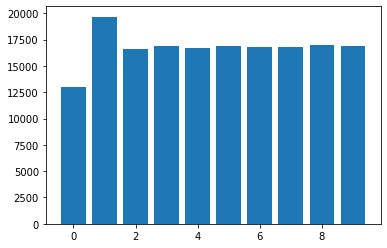

In [20]:
plt.bar(digits[:10],count[:10])

## Seq2Seq 입출력 보정

In [21]:
train_answer_bow.shape

(49000, 5)

In [22]:
train_data_bow.shape, train_answer_bow.shape, test_data_bow.shape, test_answer_bow.shape

((49000, 8), (49000, 5), (1000, 8), (1000, 5))

In [23]:
# 밑의 것을 한 칸씩 당길 것임.
# !!!!!!!!!!!!!!!!!중요한 건 지금 하는건 출력 쪽 보정임!!
train_answer_bow[:2]

array([[ 1,  6,  5, 13, 12],
       [11,  7,  3, 13, 12]], dtype=int32)

In [24]:
# 당기고 넣을 값을 만들어주자
ONE = np.ones((train_answer_bow.shape[0],1)) * vocab['PAD'] # len(data) * 1 짜리 만들고 그 값을 전부 PAD값으로 채움.
print(ONE, '\n','\n','shape :', ONE.shape)

[[12.]
 [12.]
 [12.]
 ...
 [12.]
 [12.]
 [12.]] 
 
 shape : (49000, 1)


In [25]:
train_answer_bow[...,:-1][:2] # 맨마지막꺼를 없애고 저 1x12 짜리를 맨 앞에다가 넣는 느낌임.

array([[ 1,  6,  5, 13],
       [11,  7,  3, 13]], dtype=int32)

In [26]:
train_shift_answer_bow = np.concatenate(
    [ ONE, train_answer_bow[...,:-1]] , axis=1
)

test_shift_answer_bow = np.concatenate(
    [ np.ones((test_answer_bow.shape[0],1)) * vocab['PAD'], test_answer_bow[...,:-1]] , axis=1
)

print(train_answer_bow[:5])
print(train_shift_answer_bow[:5])

print('')

print(test_answer_bow[:5])
print(test_shift_answer_bow[:5])

# 한칸이 땡겨지고 맨앞이 pad로 채워짐


[[ 1  6  5 13 12]
 [11  7  3 13 12]
 [ 1  6 13 12 12]
 [ 5 13 12 12 12]
 [ 3  0 13 12 12]]
[[12.  1.  6.  5. 13.]
 [12. 11.  7.  3. 13.]
 [12.  1.  6. 13. 12.]
 [12.  5. 13. 12. 12.]
 [12.  3.  0. 13. 12.]]

[[11  5  4 13 12]
 [ 8  3 13 12 12]
 [11  2  7 13 12]
 [ 6  4 13 12 12]
 [11  9 13 12 12]]
[[12. 11.  5.  4. 13.]
 [12.  8.  3. 13. 12.]
 [12. 11.  2.  7. 13.]
 [12.  6.  4. 13. 12.]
 [12. 11.  9. 13. 12.]]


In [27]:
# 정답으로 처리될 train / test_answer_bow를 onehot으로 바꾸는 코드를 작성
train_answer_onehot = keras.utils.to_categorical(train_answer_bow, len(vocab))
test_answer_onehot  = keras.utils.to_categorical(test_answer_bow, len(vocab))
train_answer_onehot.shape, test_answer_onehot.shape

((49000, 5, 14), (1000, 5, 14))

In [28]:
# one hot data를 읽을 수 있게 바꿔주자
def onehot2txt(onehot) :
    return "".join(invocab[step.argmax()] for step in onehot).replace('EOS','.').replace('PAD','')

onehot2txt(train_answer_onehot[0])

'165.'

In [29]:
train_text[0]

'80 + 85'

In [30]:
# bow를 읽을 수 있게 바꿔주자
def bow2txt(bow) :
    return ''.join(invocab[step] for step in bow).replace('EOS','.').replace('PAD','')

print(train_data_bow[0])
print(bow2txt(train_data_bow[0]))
print('----------')
print(train_shift_answer_bow[0])
print(bow2txt(train_shift_answer_bow[0]))

[12 12  8  0 10  8  5 13]
80+85.
----------
[12.  1.  6.  5. 13.]
165.


## Seq2Seq Modeling

In [31]:
train_data_bow.shape, train_shift_answer_bow.shape

((49000, 8), (49000, 5))

In [74]:
from keras.layers import Input, Embedding, GRU
from keras.models import Model
def seq2seq() : # model , encoder, decoder 반환
    
    embedding = Embedding(len(vocab), 5)
    
    input_x_bow = Input(shape=(8,))
    x = embedding(input_x_bow)
    z = GRU(16)(x)             # 여기까지가 Encoder 부분

    input_y_bow = Input(shape=(5,))
    y = embedding(input_y_bow)
    gru = GRU(16, return_sequences=True)

    y = gru(y, initial_state = z)
    
    softmax = Dense(len(vocab), activation='softmax')

    y = softmax(y)
    model = Model([input_x_bow, input_y_bow], y)
    model.compile(
        loss = 'categorical_crossentropy',
        optimizer = 'adam',
        metrics = ['accuracy']
    )
    
    encoder = Model(input_x_bow, z) # encoder
    
    input_y_dec = Input(shape = (1,)) # decoder에 넣을 값
    y2 = embedding(input_y_dec)

    input_z = Input(shape=(16,))

    h2 = gru(y2, initial_state = input_z)
    y2 = softmax(h2)

    decoder = Model([input_y_dec, input_z], [y2,h2])
    return model, encoder, decoder


In [75]:
model, encoder, decoder = seq2seq()

In [76]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 5)]          0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         multiple             70          input_9[0][0]                    
                                                                 input_10[0][0]                   
__________________________________________________________________________________________________
gru_4 (GRU)                     (None, 16)           1104        embedding_2[0][0]          

In [77]:
 encoder.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 8)]               0         
_________________________________________________________________
embedding_2 (Embedding)      multiple                  70        
_________________________________________________________________
gru_4 (GRU)                  (None, 16)                1104      
Total params: 1,174
Trainable params: 1,174
Non-trainable params: 0
_________________________________________________________________


In [78]:
decoder.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         multiple             70          input_11[0][0]                   
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 16)]         0                                            
__________________________________________________________________________________________________
gru_5 (GRU)                     multiple             1104        embedding_2[2][0]                
                                                                 input_12[0][0]             

In [79]:
hist = model.fit( [ train_data_bow, train_shift_answer_bow], train_answer_onehot,
          validation_data = ([test_data_bow, test_shift_answer_bow], test_answer_onehot),
          epochs = 60,
          verbose = 1)

Epoch 1/60
1532/1532 [==============================] - 11s 5ms/step - loss: 1.4309 - accuracy: 0.5691 - val_loss: 0.9356 - val_accuracy: 0.6910
Epoch 2/60
1532/1532 [==============================] - 8s 5ms/step - loss: 0.8867 - accuracy: 0.6942 - val_loss: 0.7838 - val_accuracy: 0.7184
Epoch 3/60
1532/1532 [==============================] - 8s 5ms/step - loss: 0.7664 - accuracy: 0.7194 - val_loss: 0.7313 - val_accuracy: 0.7284
Epoch 4/60
1532/1532 [==============================] - 8s 5ms/step - loss: 0.7147 - accuracy: 0.7394 - val_loss: 0.6755 - val_accuracy: 0.7616
Epoch 5/60
1532/1532 [==============================] - 8s 5ms/step - loss: 0.6591 - accuracy: 0.7650 - val_loss: 0.6233 - val_accuracy: 0.7760
Epoch 6/60
1532/1532 [==============================] - 8s 5ms/step - loss: 0.6030 - accuracy: 0.7873 - val_loss: 0.5696 - val_accuracy: 0.7962
Epoch 7/60
1532/1532 [==============================] - 8s 5ms/step - loss: 0.5570 - accuracy: 0.8079 - val_loss: 0.5298 - val_accuracy

## Result

In [80]:
# Encoder에 bow 주입, z출력 ex)
bow = plain2bow('3+1', vocab)
print(bow)
bow = tf.keras.preprocessing.sequence.pad_sequences(bow[np.newaxis,:], value = vocab['PAD'], maxlen=8)
z = encoder(bow)

print(bow.shape, bow)

[ 3 10  1 13]
(1, 8) [[12 12 12 12  3 10  1 13]]


In [81]:
z

<tf.Tensor: shape=(1, 16), dtype=float32, numpy=
array([[-0.99210143,  0.92562205, -0.8740471 ,  0.72899145,  0.99550486,
         0.8101876 ,  0.06003232, -0.977211  , -0.63005215,  0.72793174,
        -0.9369781 , -0.8989187 ,  0.81851137,  0.6828601 ,  0.4931614 ,
        -0.11095364]], dtype=float32)>

In [82]:
# z와 PAD를 이용하여 첫 번째 DECODER 값 획득 
init = np.array([vocab['PAD']])
first_pred, first_z = decoder([init,z])
print(first_z)

tf.Tensor(
[[[ 0.95884705  0.07760151 -0.8376278   0.9983256  -0.98732233
    0.81391585  0.99850273  0.5048748   0.9427187   0.3953884
   -0.29185644  0.99994785  0.9997164   0.37211376 -0.24106151
   -0.623957  ]]], shape=(1, 1, 16), dtype=float32)


In [83]:
print(first_pred)

tf.Tensor(
[[[3.6102062e-08 4.5978177e-09 3.7282468e-06 5.3687219e-02 6.2058216e-01
   3.2279032e-01 2.9330163e-03 3.4229679e-06 2.4685376e-09 2.9132384e-14
   3.3514897e-12 1.9582383e-24 3.8040280e-08 9.2832435e-09]]], shape=(1, 1, 14), dtype=float32)


In [84]:
# 가장 큰 값의 index를 이용하여 문자로 decoding
first_pred.numpy().argmax()

4

## Preprocessing